# Human-in-the-loop

When creating LangGraph agents, it is often nice to add a human in the loop component.
This can be helpful when giving them access to tools.
Often in these situations you may want to manually approve an action before taking.

This can be in several ways, but the primary supported way is to add an "interrupt" before a node is executed.
This interrupts execution at that node.
You can then resume from that spot to continue.

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install install --quiet -U langchain langchain_openai tavily-python


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key: ········
Tavily API Key: ········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolExecutor.
This is a real simple class that takes in a ToolInvocation and calls that tool, returning the output.
A ToolInvocation is any class with `tool` and `tool_input` attribute.


In [2]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

In [3]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this by converting the LangChain tools into the format for OpenAI function calling, and then bind them to the model class.


In [4]:
from langchain_core.utils.function_calling import convert_to_openai_function

functions = [convert_to_openai_function(t) for t in tools]
model = model.bind_functions(functions)

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [5]:
from langgraph.prebuilt import ToolInvocation
import json
from langchain_core.messages import FunctionMessage


# Define the function that determines whether to continue or not
def should_continue(messages):
    last_message = messages[-1]
    # If there is no function call, then we finish
    if "function_call" not in last_message.additional_kwargs:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(messages):
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return response


# Define the function to execute tools
def call_tool(messages):
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    action = ToolInvocation(
        tool=last_message.additional_kwargs["function_call"]["name"],
        tool_input=json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        ),
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(content=str(response), name=action.tool)
    # We return a list, because this will get added to the existing list
    return function_message

## Define the graph

We can now put it all together and define the graph!

In [6]:
from langgraph.graph import MessageGraph, END

# Define a new graph
workflow = MessageGraph()

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

**Persistence**

To add in persistence, we pass in a checkpoint when compiling the graph

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

**Interrupt**

To always interrupt before a particular node, pass the name of the node to compile.

In [8]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

## Preview the graph

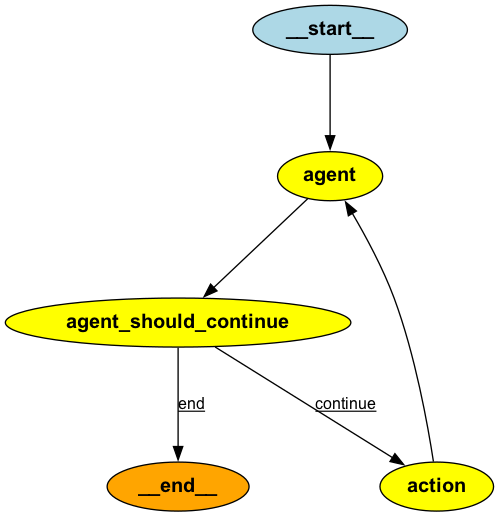

In [9]:
from IPython.display import Image

Image(app.get_graph().draw_png())

## Interacting with the Agent

We can now interact with the agent and see that it stops before calling a tool.


In [10]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "2"}}
inputs = [HumanMessage(content="hi! I'm bob")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='Hello Bob! How can I assist you today?' id='76cf2bad-06c7-4210-9258-9595d7de6dea'


In [11]:
inputs = [HumanMessage(content="what is my name?")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='Your name is Bob. How can I help you, Bob?' id='7dbe3b16-df76-4053-93a3-1db95e51954f'


In [12]:
inputs = [HumanMessage(content="what's the weather in sf now?")]
for event in app.stream(inputs, thread):
    for v in event.values():
        print(v)

content='' additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco now"}', 'name': 'tavily_search_results_json'}} id='aef7d52c-9127-409d-8428-b6a6c33ee6b4'


**Resume**

We can now call the agent again with no inputs to continue, ie. run the tool as requested.

In [13]:
for event in app.stream(None, thread):
    for v in event.values():
        print(v)

content='[{\'url\': \'https://weather.com/weather/hourbyhour/l/USCA0987:1:US\', \'content\': "recents\\nSpecialty Forecasts\\nHourly Weather-San Francisco, CA\\nBeach Hazard Statement\\nSaturday, November 25\\n5 pm\\nClear\\n6 pm\\nClear\\n7 pm\\nClear\\n8 pm\\nMostly Clear\\n9 pm\\nPartly Cloudy\\n10 pm\\nPartly Cloudy\\n11 pm\\nPartly Cloudy\\nSunday, November 26\\n12 am\\nPartly Cloudy\\n1 am\\nMostly Cloudy\\n2 am\\nMostly Cloudy\\n3 am\\nMostly Cloudy\\n4 am\\nCloudy\\n5 am\\nCloudy\\n6 am\\nMostly Cloudy\\n7 am\\nMostly Cloudy\\n8 am\\nMostly Cloudy\\n9 am\\nMostly Cloudy\\n10 am\\nPartly Cloudy\\n11 am\\nPartly Cloudy\\n12 pm\\nPartly Cloudy\\n1 pm\\nPartly Cloudy\\n2 pm\\nPartly Cloudy\\n3 pm\\nPartly Cloudy\\n4 pm\\nPartly Cloudy\\n5 pm\\nPartly Cloudy\\n6 pm\\nPartly Cloudy\\n7 pm\\nPartly Cloudy\\n8 pm\\nPartly Cloudy\\n9 pm\\nMostly Clear\\n10 pm\\nMostly Clear\\n11 pm\\nMostly Clear\\nMonday, November 27\\n12 am\\nClear\\n1 am\\nMostly Clear\\n2 am\\nMostly Clear\\n3 am\\n